# Lab05 - Vegetation Indices & KNN pixel classification

Goal of the lecture:
1. Apply different Vegetation Indices to satellite images (NDVI, NBR, NDSI)
2. Conduct pixel-based classification on a hyperspectral image with a K-Nearest Neighbor classifier
3. Evaluate the classifier with a confusion matrix

# Part I: Vegetation Indices

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from simple_downloader import download

## Downloading Sentinel-2 image

For convenience we provide 11 bands of a 13-bands sentinel-2 patch. All bands are provided in a spatial resolution of 60mx60m to simplify index analysis and visualization. The conversion to float32 and clipping has already been performed. The original band resolution can be seen below. **Please note**: in operational scenarios the lower resolution bands are usually upscaled to meet the spatial resolution of the 10mx10m bands. 

<img src="https://docs.kai-tub.tech/ben-docs/_images/ben_bands_vis.png" align="center" alt="Drawing" style="width: 900px;height:470px"/>

Source: https://docs.kai-tub.tech/ben-docs/_images/ben_bands_vis.png

Band Legend:
- B04 is Red, B03 is Green, B02 is Blue
- B05, B06, B07, B8A relate to VNIR (Visible Near Infra Red)
- B11, B12 relate to SWIR (Short Wave Infra-Red)
- B01 band for Aerosols - _not needed in this lab_
- B09 band for Water Vapor - _not needed in this lab_

In [2]:
# downlaod the preprossed sub-image from homework 2

file_path = download(
    "https://tubcloud.tu-berlin.de/s/5ajRWDmaA6qAqTG/download/lab05_river_data.npz", "./"
)
river_patch = np.load(file_path)
river_patch.files

Target file already exists!
Will skip download. To force download set `force=True`


['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B09', 'B11', 'B12']

In [3]:
channel_names = ["B04", "B03", "B02"]
river_rgb = np.stack([river_patch[b] for b in channel_names], axis=-1)
assert river_rgb.shape[-1] == 3

# Normalized Difference Vegetation Index

As you learned in the theoretical lecture, the Normalized Difference Vegetation Index (NDVI) is a standard band-ratio calculation, which is used for ecological analysis and indicates whether the target area contains live green vegetation. NDVI is a normalized measure of the difference between reflectance at near-infrared and visible bands:

NDVI = (NIR - Red) / (NIR + Red)

Alternatively, VNIR band 8A can be used instead of NIR (B08). ESA recommends this procedure in its handbook for sentinel-2 satellite because narrower band 8a does not suffer from contamination due to water vapor ([page 12/64](https://sentinel.esa.int/documents/247904/685211/sentinel-2_user_handbook)). Generally, an NDVI value close or below 0 represents minimal or no greenness and a value close to 1 represents maximum greenness.

Further reading: https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/

In [4]:
#Finding the difference
def calc_normalized_diff(b1, b2):
    """
    Calculate the normalized difference over two n-dimensional numpy arrays.
    src: https://earthpy.readthedocs.io/en/latest/_modules/earthpy/spatial.html

    Parameters
    ----------
    b1, b2 : Two bands as numpy arrays

    Returns
    ----------
    n_diff : (b1-b2) / (b1+b2) calculation.
    """

    # Ignore warning for division by zero
    with np.errstate(divide="ignore"):
        n_diff = (b1 - b2) / (b1 + b2)

    # Set inf values to nan and provide custom warning
    if np.isinf(n_diff).any():
        warnings.warn(
            "Divide by zero produced infinity values that will be replaced " "with nan values",
            Warning,
        )
        n_diff[np.isinf(n_diff)] = np.nan

    # Mask invalid values
    if np.isnan(n_diff).any():
        n_diff = np.ma.masked_invalid(n_diff)

    return n_diff

In [5]:
#Normalize the data
def quant_norm_data(
    data: np.ndarray, lower_quant: float = 0.01, upper_quant: float = 0.99
) -> np.ndarray:
    """
    Normalize the data by quantiles `lower_quant/upper_quant`.
    The quantiles are calculated globally/*across all channels*.
    """
    masked_data = np.ma.masked_equal(data, 0)
    lq, uq = np.quantile(masked_data.compressed(), (lower_quant, upper_quant))
    data = np.clip(data, a_min=lq, a_max=uq)
    data = (data - lq) / (uq - lq)
    return data

In [6]:
#Plotting the image
def plot_rgb_vs_index(rgb_image, index_values, index_name):
    idx2cmap = {"ndvi": "PiYG", "nbr": "PiYG", "ndsi": "jet"}
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    ax[0].axis("off")
    ax[0].set_title("RGB")
    ax[0].imshow(rgb_image)

    ax[1].axis("off")
    ax[1].set_title(index_name.upper())
    im = ax[1].imshow(index_values, cmap=idx2cmap[index_name], vmin=-1, vmax=1)

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.90, 0.25, 0.02, 0.5])
    fig.colorbar(im, cax=cbar_ax)

In [7]:
red_band = river_patch["B04"]
vnir_band = river_patch["B8A"]

ndvi = calc_normalized_diff(vnir_band, red_band)
river_rgb = quant_norm_data(river_rgb)

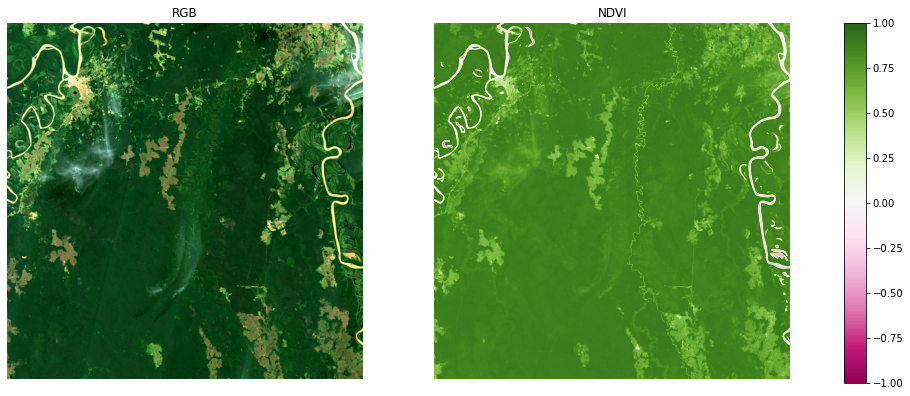

In [8]:
plot_rgb_vs_index(river_rgb, ndvi, index_name="ndvi")

# Normalized Burn Ratio 

The Normalized burn ratio (NBR) is used to identify burned areas. Usually, you need two images acquired at different times (before and after the fire). The formula is similar to NDVI, except that it uses near-infrared and shortwave-infrared bands.

NBR = (NIR - SWIR) / (NIR + SWIR)

Also here, we will exchange NIR (B08) by VNIR band 8a. Values below 0 indicate burned areas.

Further information: https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/. 

In [9]:
swir_band = river_patch["B11"]

nbr = calc_normalized_diff(vnir_band, swir_band)

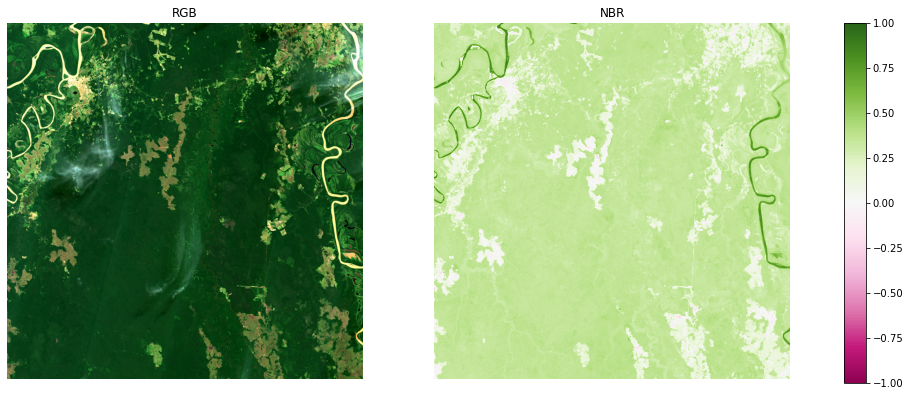

In [10]:
plot_rgb_vs_index(river_rgb, nbr, "nbr")

### A closer look actually reveals some burned areas in the amazon:

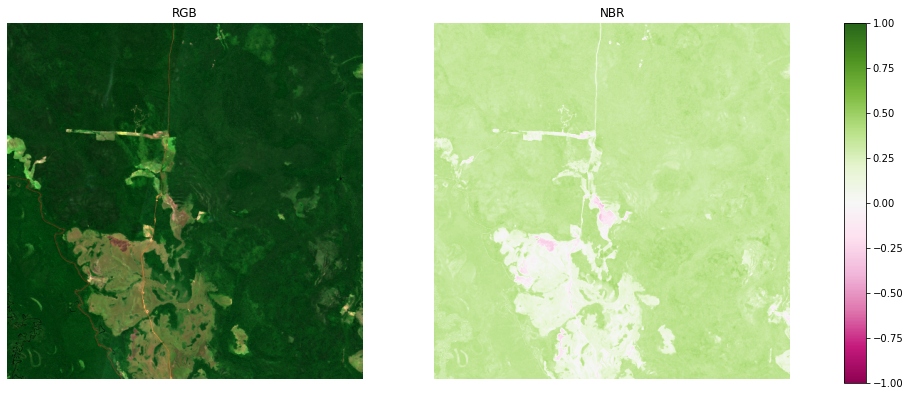

In [11]:
plot_rgb_vs_index(river_rgb[1200:1700, 1100:1600], nbr[1200:1700, 1100:1600], "nbr")

# In-course practice I (Normalized Difference Snow Index)

The Normalized Difference Snow Index (NDSI) is an index that shows the presence of snow in a pixel. The formula is similar to NDVI, and NBR except that it uses green and shortwave-infrared bands:

NDSI = (Green - SWIR) / (Green + SWIR)

The range between 0 and 1 can be associated with snow. Any value below 0 indicates the absence of snow.

**Task**: To do this practice, we select another patch which includes snow. The following cell will automatically download the patch. It is preprocessed in the same way as the river patch is. Compute the NDSI for the the snowpatch. Select and quantile-normalize the RGB channels for visualization purposes.

In [12]:
file_path = download(
    "https://tubcloud.tu-berlin.de/s/fmbBqbojf3GA7Em/download/lab05_snow_data.npz",
    target_dir="data",
)
snow_patch = np.load(file_path)
snow_patch.files

Target file already exists!
Will skip download. To force download set `force=True`


['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B09', 'B11', 'B12']

In [13]:
### TASK I: compute snow_rgb & ndsi

#Create an RGB band
channel_names = ["B04", "B03", "B02"]
snow_rgb = np.stack([river_patch[b] for b in channel_names], axis=-1)
assert snow_rgb.shape[-1] == 3


In [14]:
#Select only the green band
green_band = snow_patch["B03"]
SWIR = snow_patch["B11"]

NDSI = calc_normalized_diff(green_band, SWIR)

/tmp/ipykernel_24/236472336.py:18: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b1 - b2) / (b1 + b2)


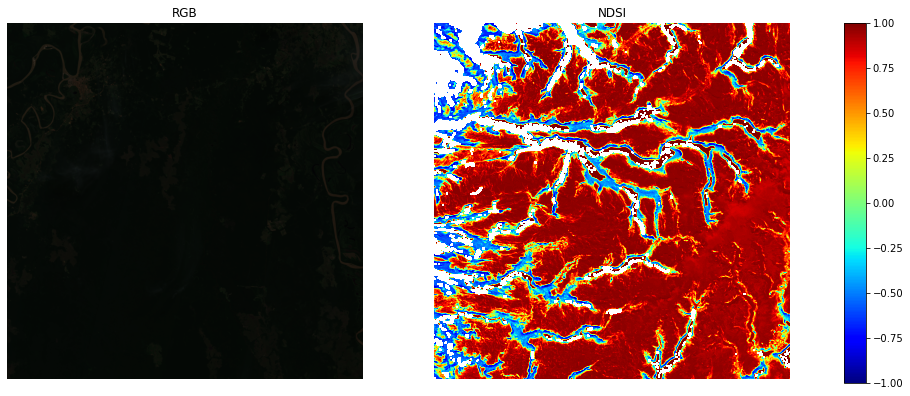

In [15]:
plot_rgb_vs_index(snow_rgb, NDSI, index_name="ndsi")

# Part II: Pixel-Based Supervised Classification with K-Nearest Neighbors (KNN)

k-Nearest Neighbor is a supervised algorithm, which is usually used for classification tasks. It measures the distances between the training samples (shown by circles in the figure) and unseen test data (is shown by *star* in the figure) and makes the prediction (class label) accordingly.

<img src="https://miro.medium.com/max/1400/1*2zYNhLc522h0zftD1zDh2g.png" align="left" alt="Drawing" style="width: 500px;"/>
    
    
    
    
credit: medium.com/@equipintelligence

For this course we use the "IndianPines" hyperspectral image selected from Hyperspectral (HS) datasets that are publicly available at http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes.

This notebook downloads the dataset automatically for you into "./data" by coveniently making use of the get_dataset() function from the DeepHyperX repository at https://gitlab.inria.fr/naudeber/DeepHyperX. 

## Import Packages

In [16]:
import sys

sys.path.append("/tmp/DeepHyperX")

In [17]:
from datasets import get_dataset
import matplotlib
import spectral

## Download Dataset

This notebook downloads the "IndianPines" hyperspectral image and its corresponding ground reference map (class labels assigned per pixel). 

- 200 bands
- 16 land cover classes, namely: 'Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers'.

**Note:** that in the classification map some areas are not labeled ('Undefined') that have to be excluded.

Download also available via TUB-cloud: https://tubcloud.tu-berlin.de/s/oAdtGjHzTTJH7Xc/download/IndianPines.zip.

In [25]:
hyper_datacube, gt, labels, ignored_labels, _, _ = get_dataset(
    "IndianPines", target_folder="./data/"
)
print(hyper_datacube.shape)
num_bands = hyper_datacube.shape[-1]
num_classes = len(labels)

(145, 145, 200)


## Visualization of the Image and Land Cover Map (Classification Map)

In [26]:
# create handles for legend
cmap = matplotlib.cm.get_cmap("tab20")
handles = [matplotlib.patches.Patch(color=cmap(i), label=labels[i]) for i in range(17)]

In [27]:
# adjusts colormap according to classes present in label map
def adjust_cmap(data, cmap_name):
    cmap = matplotlib.cm.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, cmap.N))
    adj_colors = colors[: np.max(data) + 1]
    return matplotlib.colors.ListedColormap(adj_colors)

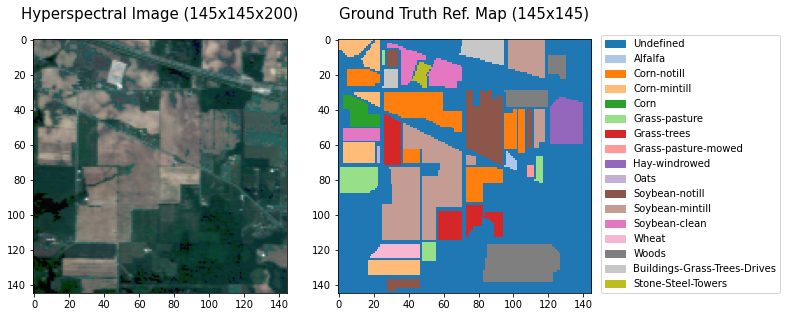

In [28]:
hypercube_rgb = spectral.get_rgb(hyper_datacube, bands=(31, 15, 11))

fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title(
    "Hyperspectral Image ({}x{}x{})".format(*hyper_datacube.shape), fontsize=15, pad=20
)
axes[0].imshow(hypercube_rgb)
axes[1].set_title("Ground Truth Ref. Map ({}x{})".format(*gt.shape), fontsize=15, pad=20)
axes[1].imshow(gt, cmap=adjust_cmap(gt, "tab20"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

## Creating Train and Test sets

We need to create two sets for train and test purposes.

In the pixel-based classification each set (test/train) includes a certain number of samples. Each sample represents a pixel with its spectral values and its assigned class label. For the IndianPines dataset each sample consists of 200 spectral band values and one label (between 0-16).

In [29]:
def sample_gt(gt, train_percentage):
    """
    Extract a fixed percentage of samples from an array of labels.

    Parameter
    ---------
    gt                : a 2D array of int labels
    train_percentage  : [0, 1] float

    Return
    ------
    train_gt, test_gt : 2D arrays of int labels

    """
    train_gt, test_gt = gt.copy(), gt.copy()

    for c in np.unique(gt):
        mask = gt == c
        for x in range(gt.shape[0]):
            first_half_count = np.count_nonzero(mask[:x, :])
            if first_half_count / np.count_nonzero(mask) > train_percentage:
                break

        train_mask = mask.copy()
        train_mask[:x, :] = 0
        train_gt[train_mask] = 0

        test_mask = mask.copy()
        test_mask[x:, :] = 0
        test_gt[test_mask] = 0

    return train_gt, test_gt

In [32]:
#80% data for training while 20% for testing
train_gt, test_gt = sample_gt(gt, 0.8)

n_train = np.count_nonzero(train_gt)
n_test = np.count_nonzero(test_gt)
n_total = np.count_nonzero(gt)

print("Train:  {} samples selected (over {})".format(n_train, n_total))
print("Test:   {} samples selected (over {})".format(n_test, n_total))

Train:  8337 samples selected (over 10249)
Test:   1912 samples selected (over 10249)


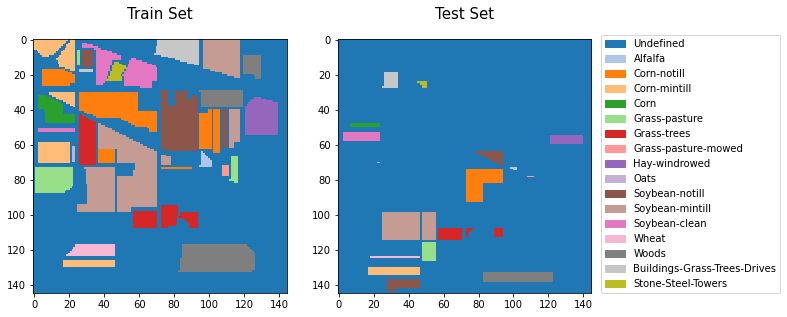

In [33]:
#We plot our train and test data
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("Train Set", fontsize=15, pad=20)
axes[0].imshow(train_gt, cmap=adjust_cmap(gt, "tab20"), interpolation="none")
axes[1].set_title("Test Set", fontsize=15, pad=20)
axes[1].imshow(test_gt, cmap=adjust_cmap(gt, "tab20"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

In [35]:
def build_dataset(hyper_cube, gt, ignored_labels=None):
    """Flatten HyperCube to X, y for training."""
    assert hyper_cube.shape[:2] == gt.shape[:2]
    samples, labels = [], []
    classes = set(np.unique(gt)) - set(ignored_labels)

    for cl in classes:
        indices = np.nonzero(gt == cl)
        samples += list(hyper_cube[indices])
        labels += len(indices[0]) * [cl]

    # shuffle data
    zipped = list(zip(samples, labels))
    np.random.shuffle(zipped)
    samples, labels = zip(*zipped)

    return np.asarray(samples), np.asarray(labels)

In [40]:
X_train, y_train = build_dataset(hyper_datacube, train_gt, ignored_labels=ignored_labels)
X_test, y_test = build_dataset(hyper_datacube, test_gt, ignored_labels=ignored_labels)

## In-course practice II

Plot spectral signature of 3 different classes. These are the features that we use for classification.
You can select one single sample or calculate the average of samples for each class from train samples.

In [ ]:
### TASK II: Choose different classes

corn_idx = np.array(np.where(y_train ==4

In [ ]:
### TASK II: Plot spectral signatures

## KNN Classifer

As initial we select the first NN (1-NN). Training the classifier on the train samples and then performing evaluation on the test samples.

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [38]:
def predict(model, X):
    y_pred = []
    for i in range(0, len(X), 500):
        y_pred += list(model.predict(X[i : i + 500]))
    return np.array(y_pred)

In [39]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = predict(knn, X_test)

## Evaluation Metrics

TP = classified correctly as True (sample blongs to a class)

TN = classified correctly as False ((sample not blongs to a class)

P + N = all the samples

Accuracy = (TP + TN) / (P + N)

This information can be extract from confusion matrix. Confusion Matrix  is a table that describes the performance of a classifier over the test set. You can compute Confusion Matrix manually, however we use Scikit Library to calculate it:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_001.png)

In [41]:
def metrics(predictions, targets, ignored_labels=[], class_labels=None):
    ignored_mask = np.zeros(targets.shape, dtype=bool)
    for l in ignored_labels:
        ignored_mask[targets == l] = True
    ignored_mask = ~ignored_mask
    targets = targets[ignored_mask]
    predictions = predictions[ignored_mask]

    results = {}

    if class_labels is None:
        class_labels = range(len(np.unique(targets)))

    cm = confusion_matrix(targets, predictions)

    results["cm"] = cm
    results["overall_acc"] = accuracy_score(targets, predictions)
    results["report"] = classification_report(
        targets, predictions, target_names=class_labels, zero_division=0, digits=4, output_dict=True
    )
    return results

In [44]:
results = metrics(y_pred, y_test, ignored_labels=ignored_labels, class_labels=labels[1:])

## Confusion Matrix Visualization

Visualize Confusion Matrix (normalize and not normalized) as it shown in the image

In [45]:
results["overall_acc"]

0.1401673640167364

Text(77.99999999999999, 0.5, 'Predicted Label')

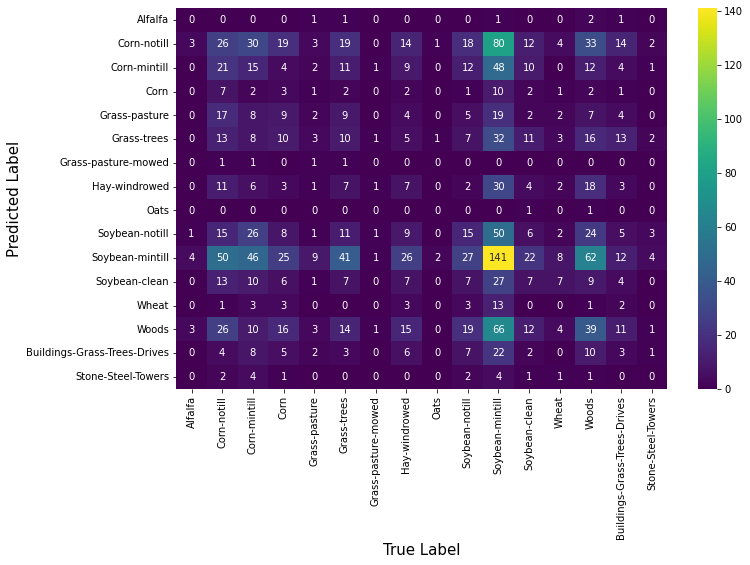

In [46]:
import seaborn as sns

plt.subplots(1, 1, figsize=(11, 7))
sns.heatmap(
    results["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=labels[1:],
    yticklabels=labels[1:],
    annot=True,
)
plt.xlabel("True Label", fontsize=15)
plt.ylabel("Predicted Label", fontsize=15)

## In-course practice III

* Reduce the number of training samples into 2% and observe how the accuracy changes

* Instead of 1-NN, use 3-NN and 7-NN for KNN classifier and observe how the accuracy changes.

In [48]:
### TASK III: Retrain with 2% of data
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train[:100], y_train[:100])
y_pred = predict(knn, X_test)
results = metrics(y_pred, y_test, ignored_labels=ignored_labels, class_labels=labels[1:])
results["overall_acc"]

0.5434100418410042

In [49]:
### TASK III: Retrain with K=3, K=7
### K = 3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = predict(knn, X_test)
results = metrics(y_pred, y_test, ignored_labels=ignored_labels, class_labels=labels[1:])
results["overall_acc"]

0.6338912133891214

In [50]:
#k = 7
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = predict(knn, X_test)
results = metrics(y_pred, y_test, ignored_labels=ignored_labels, class_labels=labels[1:])
results["overall_acc"]

0.6359832635983264